In [1]:
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
os.getcwd()

'C:\\Users\\p.schambach\\Desktop\\DSR\\drone_steering\\models\\playground'

In [5]:
os.chdir('../..')

In [6]:
from app_local.module import DataEnsembler, GestureTransformer

In [7]:
is_frame_based = False

In [8]:
de = DataEnsembler(ms_per_frame=120)
de.investigate_available_datafiles(data_dir='data/gesture/', is_frame_based = is_frame_based)

In [9]:
de.load_data()

# Rescaling and Interpolation
use_rescaling_to_true_length = True
use_interpolation = True
is_verbose = True

if use_rescaling_to_true_length:
        de.rescale_data_frames( time_of_first_frame = 'avg', verbose = is_verbose)

if use_interpolation:
    if is_frame_based:
        de.interpolate_and_convert_framebased_labels(new_frmlen = 50, verbose = is_verbose)
    else:
        de.interpolate_data_frames( frmlen = 50, verbose = is_verbose)
  

Current Index: 1
Calling DataFrameInterpolator.scaleDataFrame method with current length 60562.0 and actual length 63117
Using 'avg' to calculate new time of first frame: 0.0 ==> 112
Current Index: 2
Calling DataFrameInterpolator.scaleDataFrame method with current length 63629.0 and actual length 64048
Using 'avg' to calculate new time of first frame: 0.0 ==> 123
Current Index: 4
Calling DataFrameInterpolator.scaleDataFrame method with current length 62303 and actual length 62915
Using 'avg' to calculate new time of first frame: 0 ==> 118
Current Index: 5
Calling DataFrameInterpolator.scaleDataFrame method with current length 63629 and actual length 64248
Using 'avg' to calculate new time of first frame: 0 ==> 131
Current Index: 6
Calling DataFrameInterpolator.scaleDataFrame method with current length 66095.0 and actual length 66712
Using 'avg' to calculate new time of first frame: 0.0 ==> 106
Current Index: 8
Calling DataFrameInterpolator.scaleDataFrame method with current length 6366

In [10]:
if is_frame_based:
    de.assemble_data()
else:
    de.assemble_data(tolerance_range = 600, max_error = 550)
    
de.display_information()

i: 0 	shape X: (1310, 18, 16) 	shape y: (1310,) 	count: 139
i: 1 	shape X: (1244, 18, 16) 	shape y: (1244,) 	count: 168
i: 2 	shape X: (1263, 18, 16) 	shape y: (1263,) 	count: 192
i: 3 	shape X: (1383, 18, 16) 	shape y: (1383,) 	count: 279
i: 4 	shape X: (1240, 18, 16) 	shape y: (1240,) 	count: 156
i: 5 	shape X: (1267, 18, 16) 	shape y: (1267,) 	count: 180
i: 6 	shape X: (1317, 18, 16) 	shape y: (1317,) 	count: 156
i: 7 	shape X: (1242, 18, 16) 	shape y: (1242,) 	count: 117
i: 8 	shape X: (1273, 18, 16) 	shape y: (1273,) 	count: 132
i: 9 	shape X: (1264, 18, 16) 	shape y: (1264,) 	count: 144
i: 10 	shape X: (1349, 18, 16) 	shape y: (1349,) 	count: 125
i: 11 	shape X: (1217, 18, 16) 	shape y: (1217,) 	count: 96
i: 12 	shape X: (1278, 18, 16) 	shape y: (1278,) 	count: 132
i: 13 	shape X: (1207, 18, 16) 	shape y: (1207,) 	count: 0
i: 14 	shape X: (1186, 18, 16) 	shape y: (1186,) 	count: 13
i: 15 	shape X: (1216, 18, 16) 	shape y: (1216,) 	count: 13
i: 16 	shape X: (1218, 18, 16) 	shape y

In [11]:
feature_names = list(de.feature_names)
feat_dict = {feature:feature_names.index(feature) for feature in feature_names}

In [12]:
def plot_charts(de, file_id, tail=5, head=5, plots_per_row=30, body_part='leftWrist', is_frame_based = True):

    global movements
    
    kx = body_part + '_x'
    ky = body_part + '_y'

    lgen = de.LabelGenerators[file_id]
    y = lgen.y
    n = len(lgen.y)

    gt = GestureTransformer(byrow=True, feature_names=feature_names)
    X = gt.transform(lgen.X)
    s = lgen.X.shape[1]

    d = lgen.labeled_data
    dims = d[feature_names].shape
    D = d[feature_names].values.reshape(1,dims[0],dims[1])
    D = gt.transform(D).reshape(dims[0],dims[1])
    Dx = D[:,feat_dict[kx]]
    Dy = D[:,feat_dict[ky]]    
    
    for j in range(n // plots_per_row + 1):
        
        plt.figure(figsize=(2 * plots_per_row, 2))
        
        for i in range (plots_per_row):
            plt.subplot(1, plots_per_row, i + 1)
            index = j*plots_per_row + i

            # specify axes range
            axes = plt.gca()
            axes.set_xlim([-2,2])
            axes.set_ylim([-2,2])
            axes.get_yaxis().set_visible(False)
            axes.get_xaxis().set_visible(False)

            if index < n:
                title_suffix = ''
                if (int(y[index])>0):
                    axes.set_facecolor((0.95, 0.95, 0.95))
                    title_suffix = ' | ' + movements[int(y[index])]

                # movement
                l1, u1 = max(0,index - s), index
                plt.plot(Dx[l1:u1],Dy[l1:u1],color = "xkcd:baby blue")

                # past
                l2, u2 = max(0,index - s - tail), max(0,index-s)
                plt.plot(Dx[l2:u2+1],Dy[l2:u2+1],linestyle = "--",color = "green")

                # future
                l3, u3 = index, min(index + head,dims[0])
                plt.plot(Dx[l3:u3],Dy[l3:u3],linestyle = "--",color = "red")
                
                # current frame
                plt.plot(Dx[u1-1],Dy[u1-1],color = "xkcd:baby blue",marker = "o")
                
                if is_frame_based:
                    plt.title(str(index) + title_suffix)
                else:
                    plt.title(str(index) + "/" + str(round(lgen.sequence_end_time[index]/1000,2)) + " l=" + str(int(y[index])))
                

        plt.show()
        plt.close()    

Available body parts:
```
leftElbow
leftHip
leftShoulder
leftWrist
rightElbow
rightHip
rightShoulder
rightWrist
```

In [13]:
de.combined_data_files_df

,filename_features,filename_labels
0,features_flip_c_01_120.csv,labels_flip_c_01.csv
1,features_flip_c_02_120.csv,labels_flip_c_02.csv
2,features_flip_c_03_120.csv,labels_flip_c_03.csv
3,features_flip_l_01_120.csv,labels_flip_l_01.csv
4,features_flip_l_02_120.csv,labels_flip_l_02.csv
5,features_flip_l_03_120.csv,labels_flip_l_03.csv
6,features_flip_p_01_120.csv,labels_flip_p_01.csv
7,features_land_c_01_120.csv,labels_land_c_01.csv
8,features_land_c_02_120.csv,labels_land_c_02.csv
9,features_land_c_03_120.csv,labels_land_c_03.csv


**Legend:**<br>
<span style="color:blue">gesture</span><br>
<span style="color:red">frames *after* gesture</span><br>
<span style="color:green">frames *before* gesture</span>

In [14]:
movements = {0: 'not detected',
             1: 'takeoff',
             2: 'move',
             3: 'flip',
             4: 'left',
             5: 'right',
             6: 'land'}

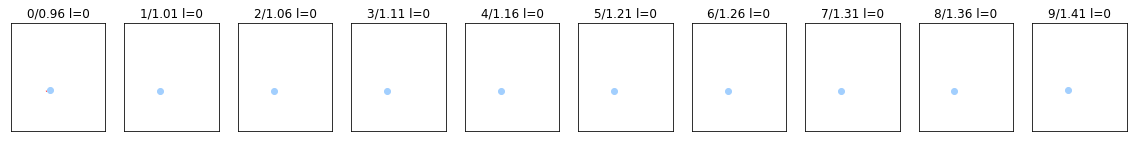

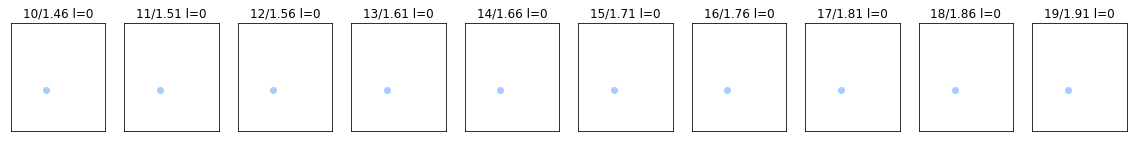

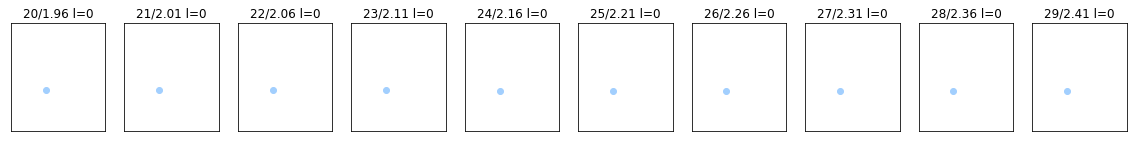

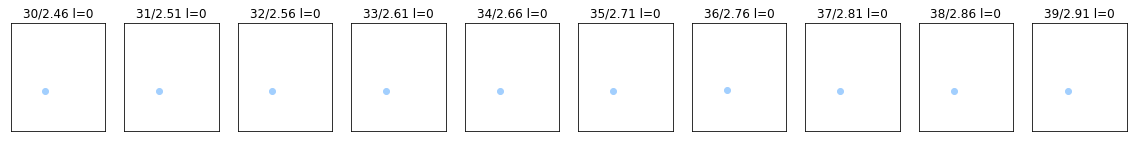

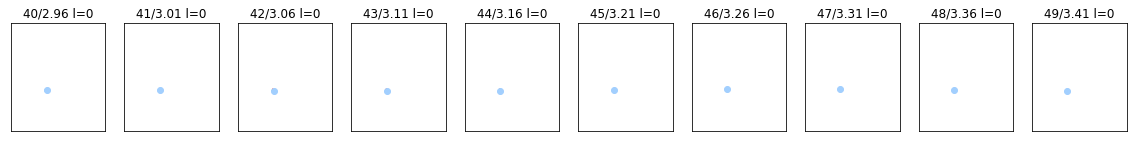

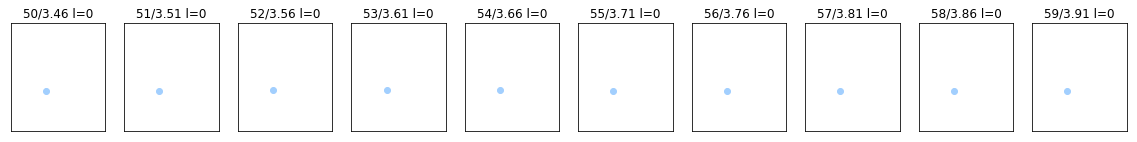

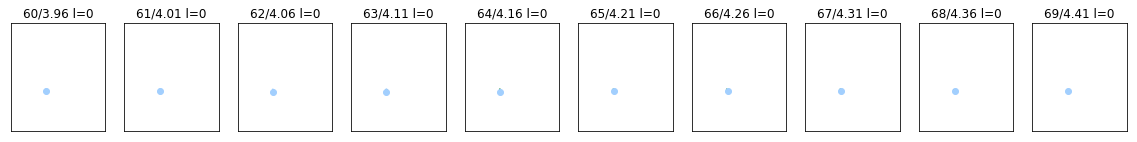

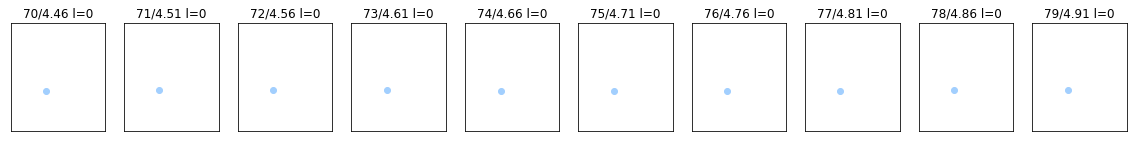

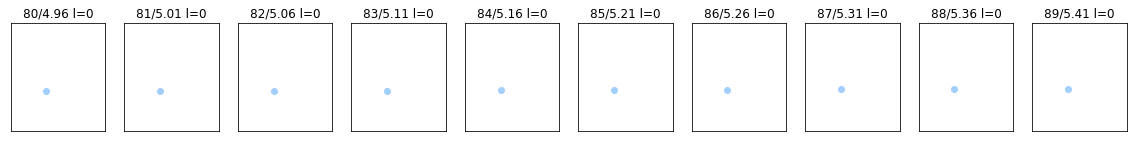

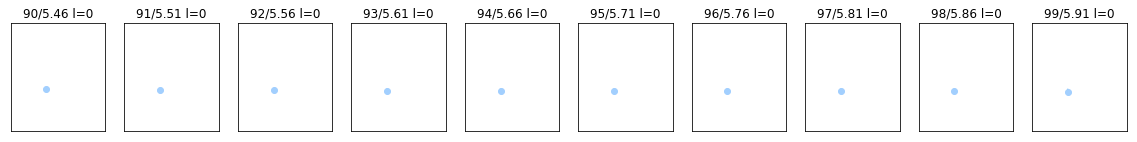

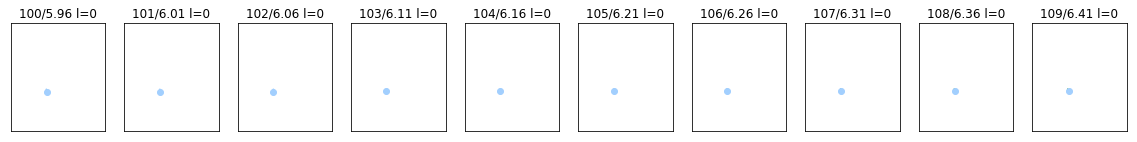

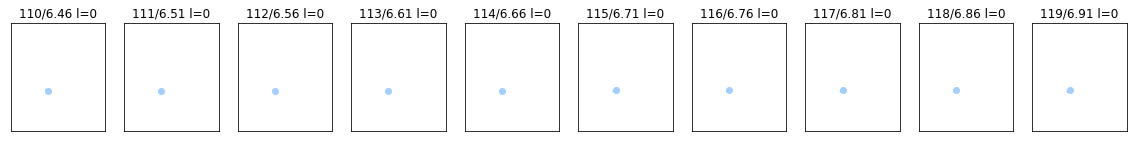

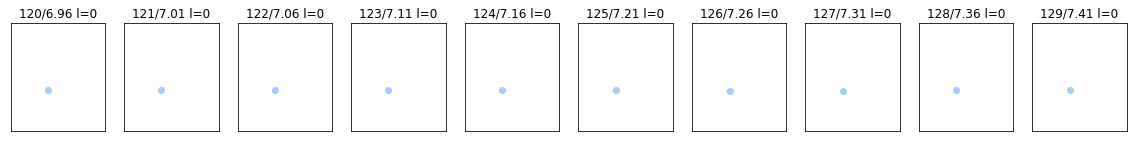

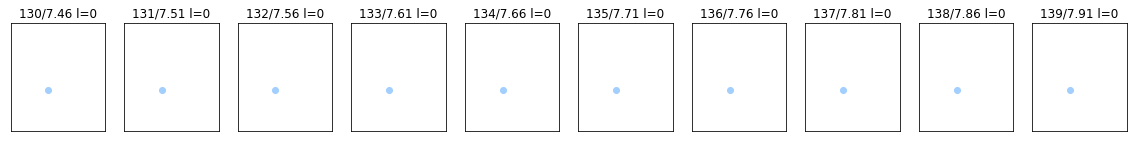

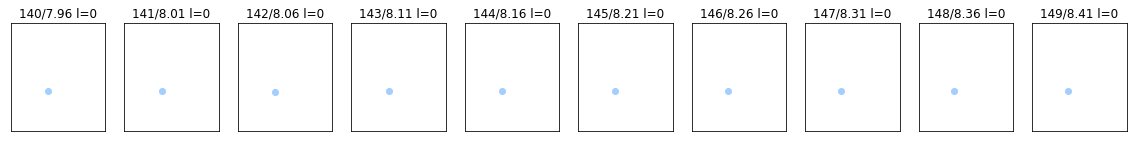

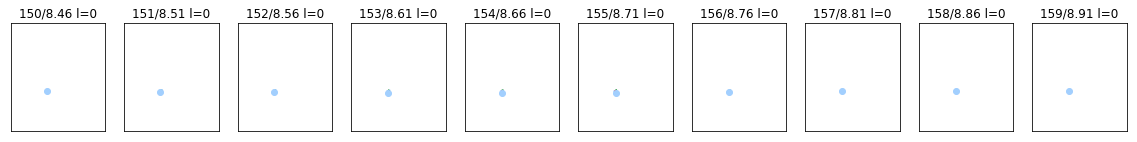

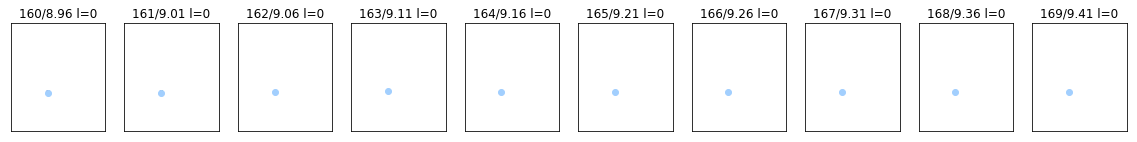

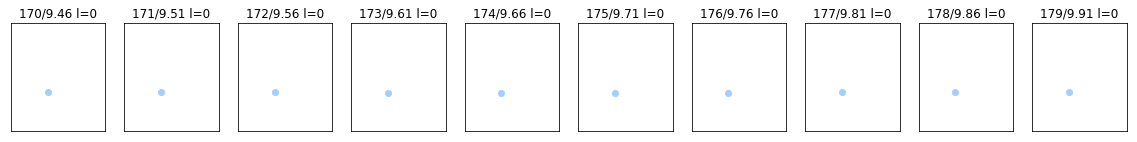

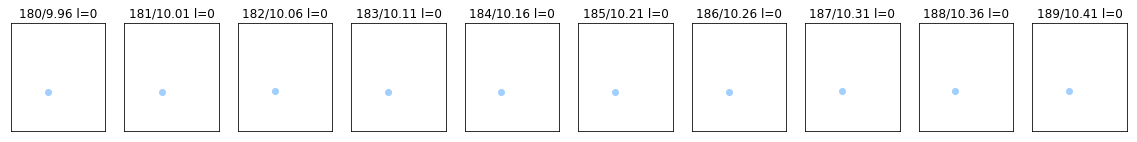

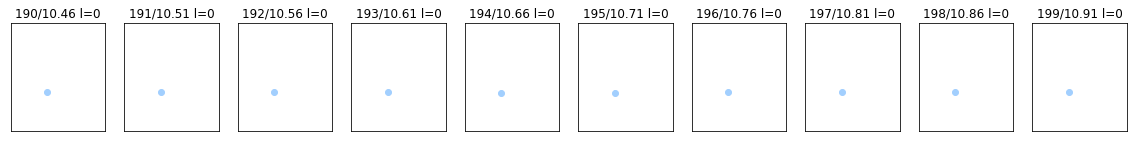

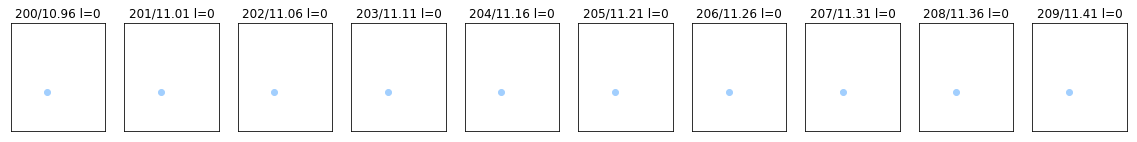

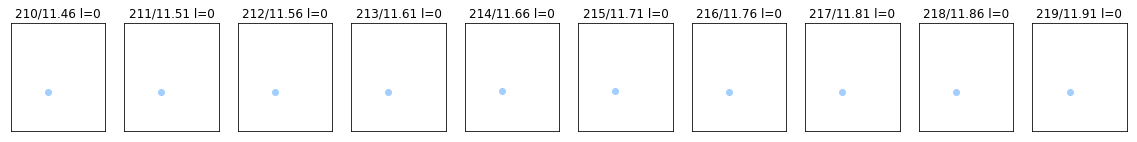

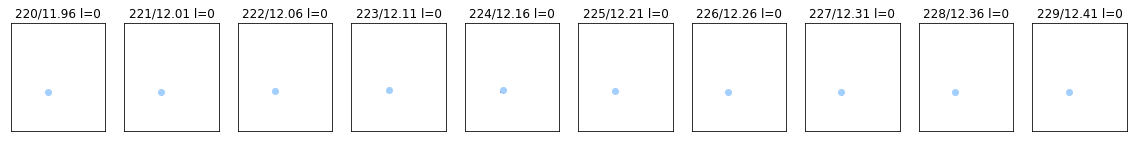

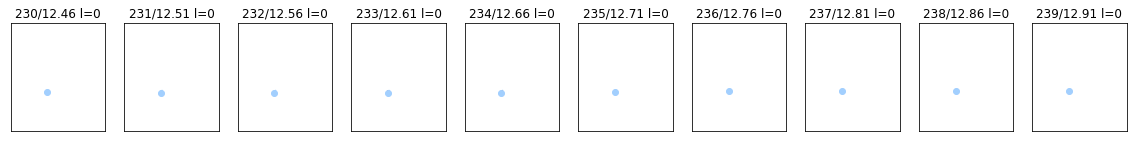

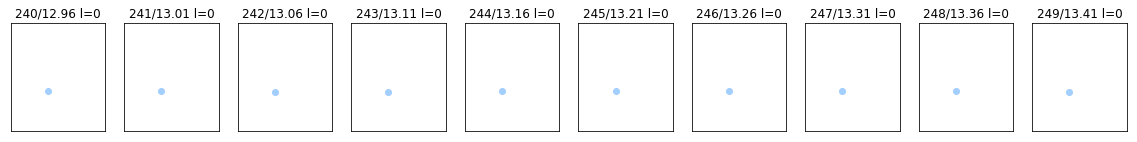

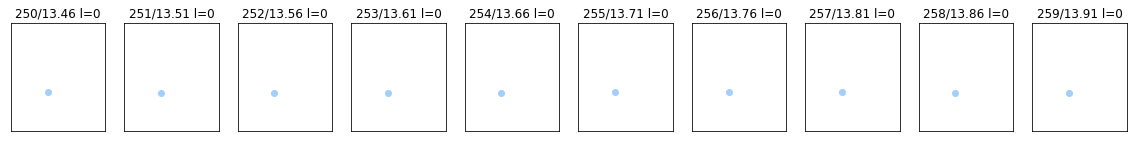

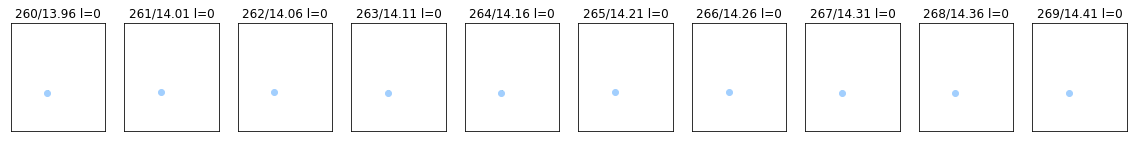

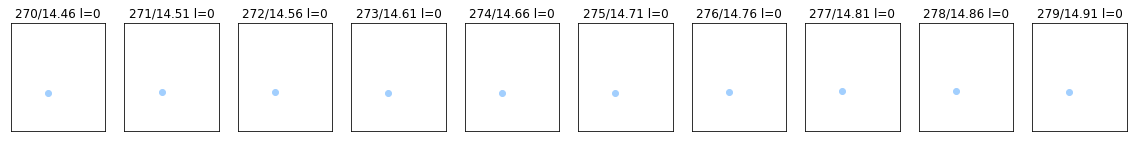

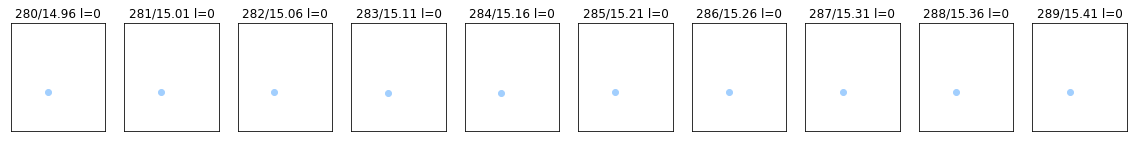

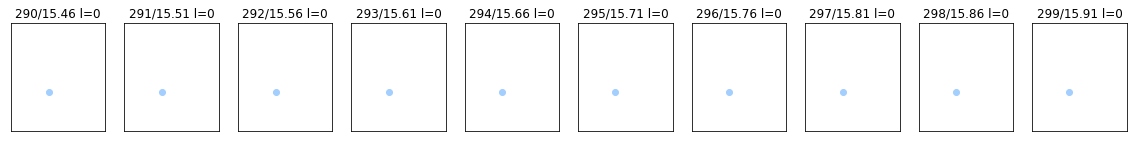

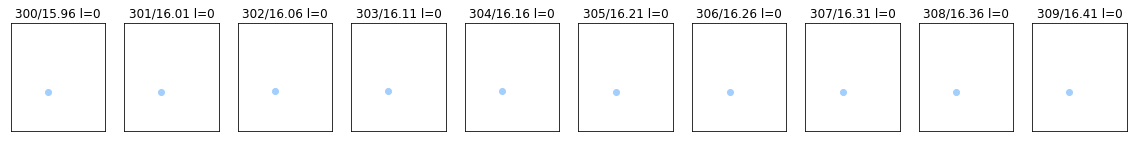

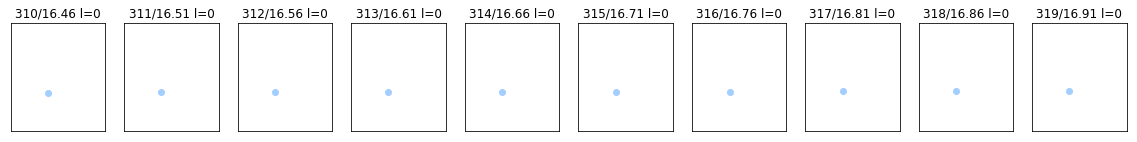

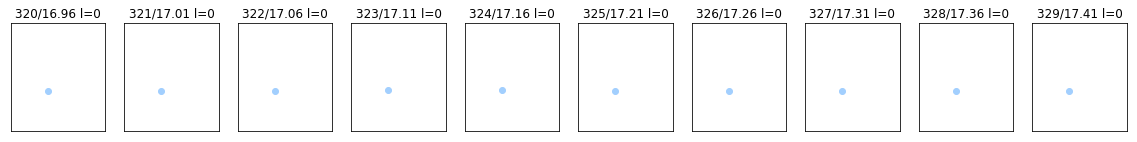

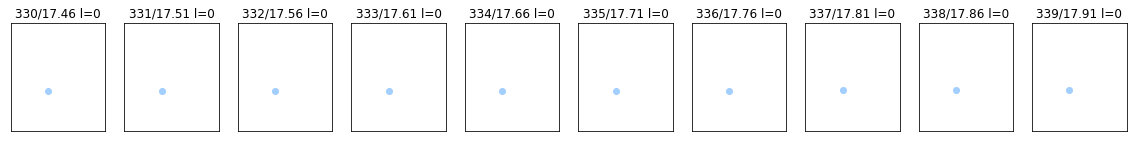

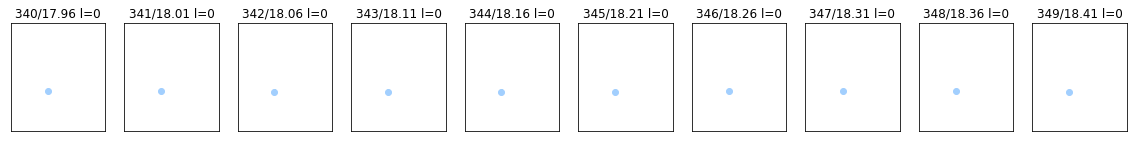

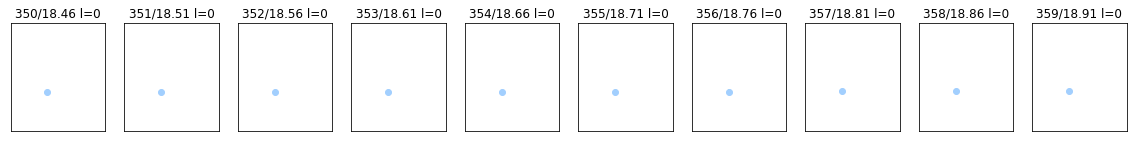

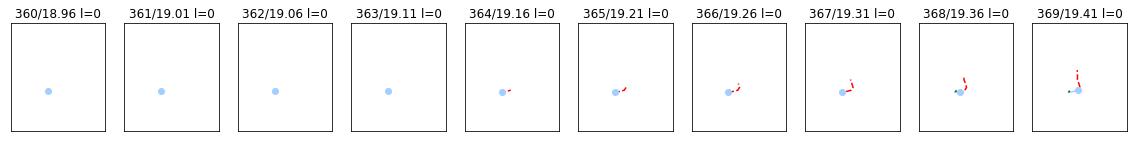

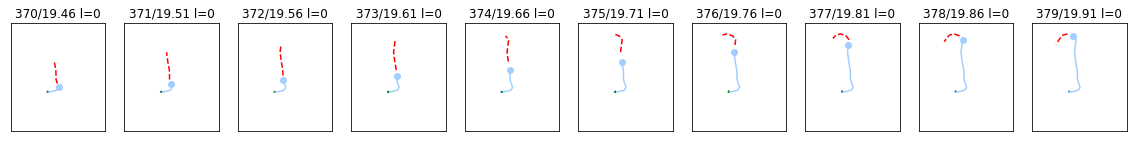

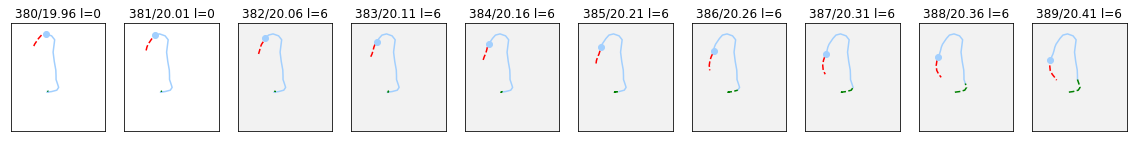

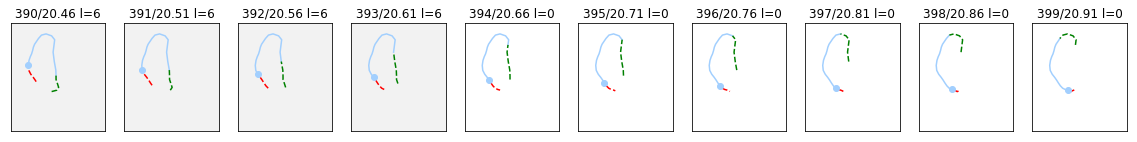

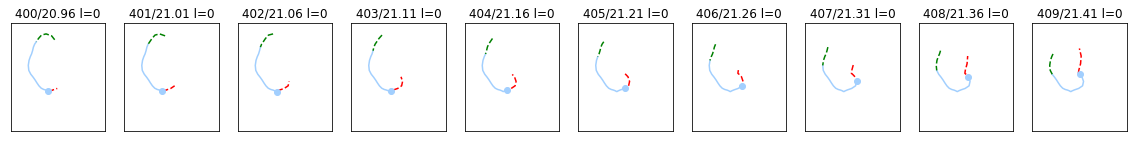

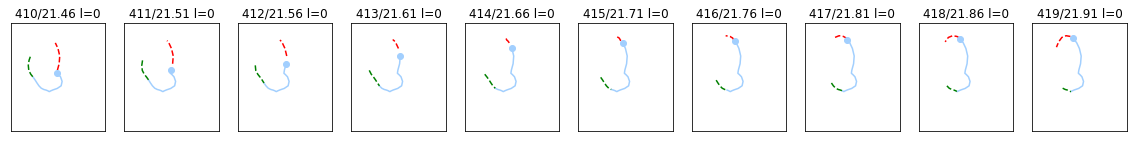

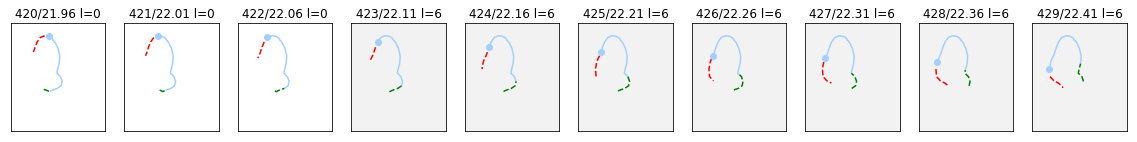

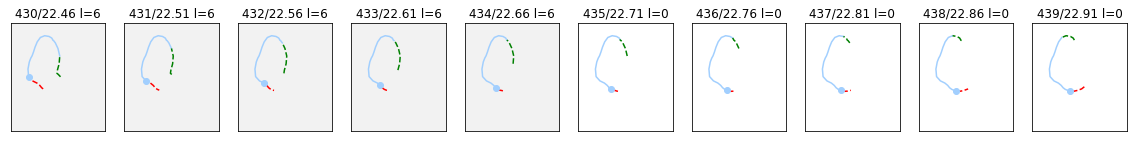

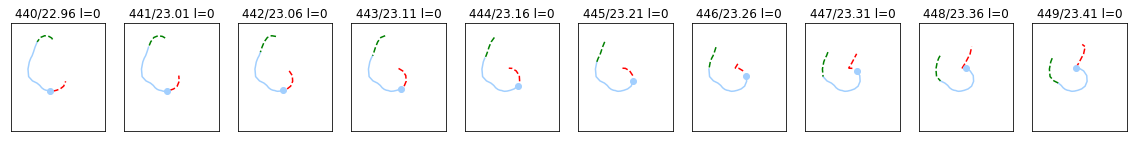

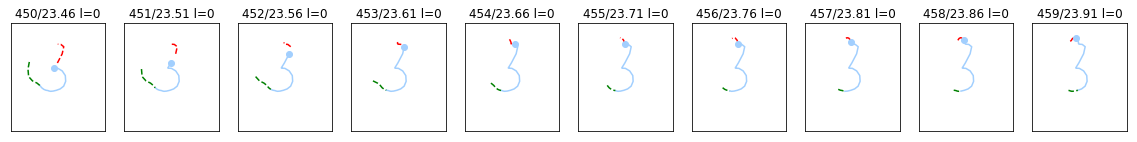

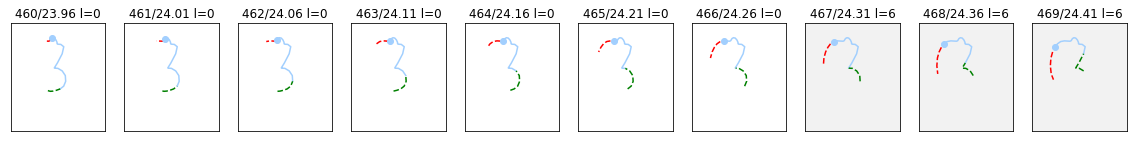

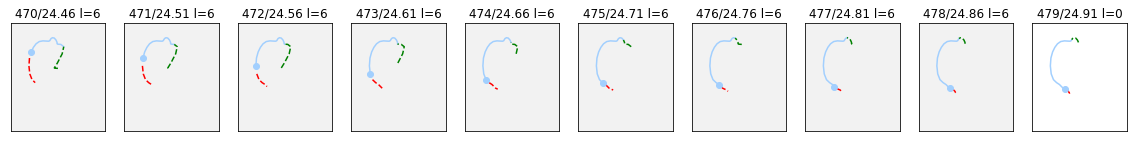

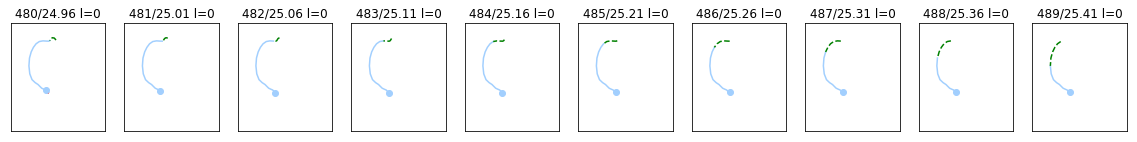

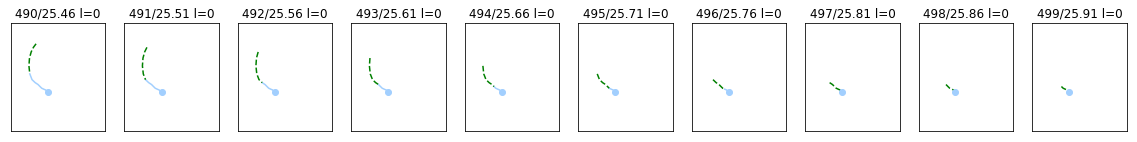

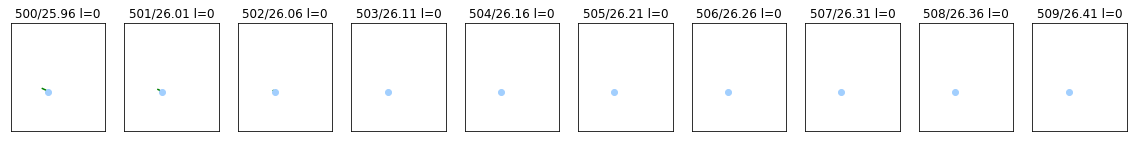

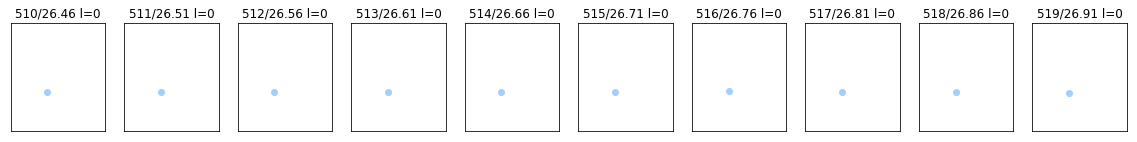

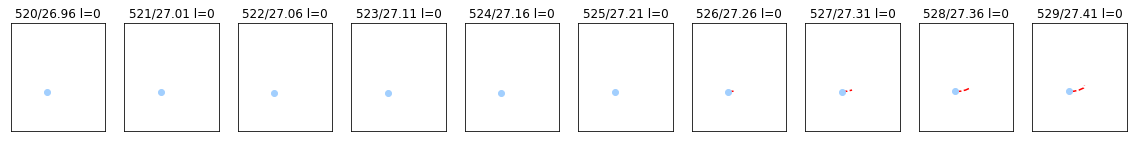

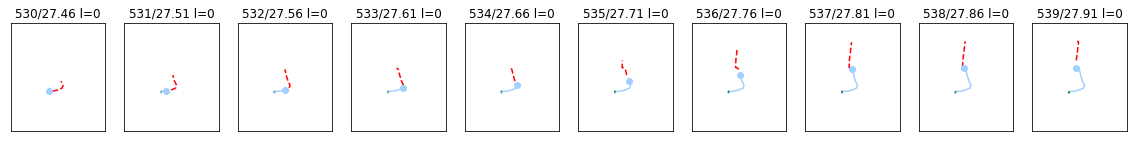

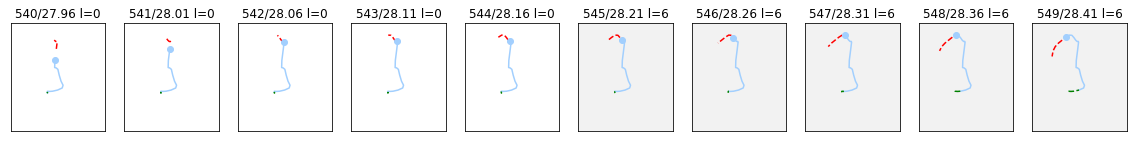

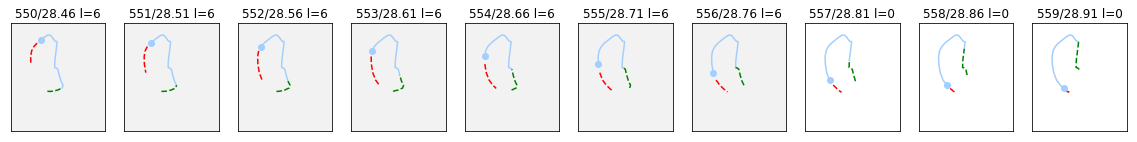

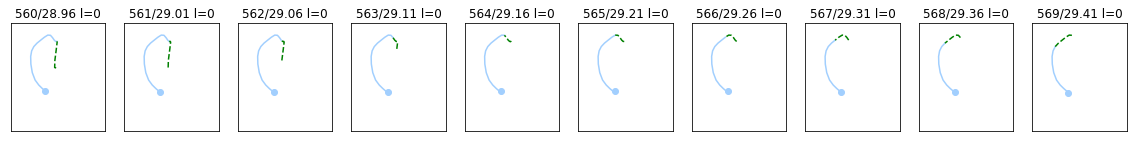

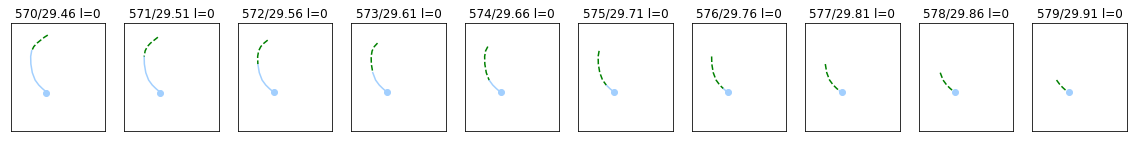

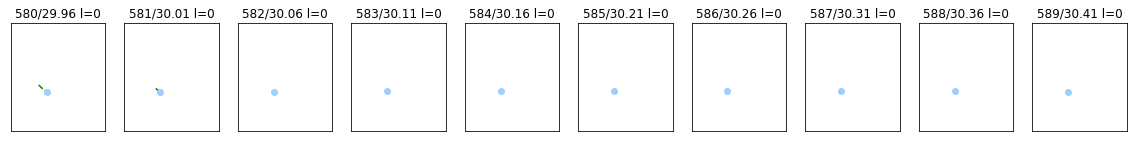

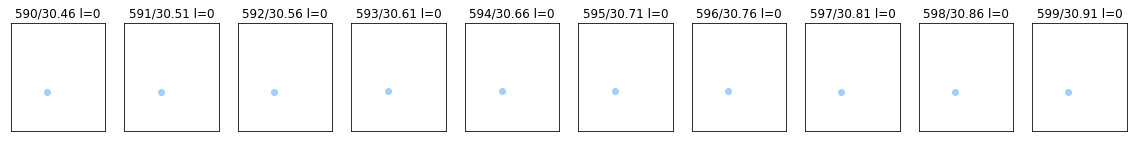

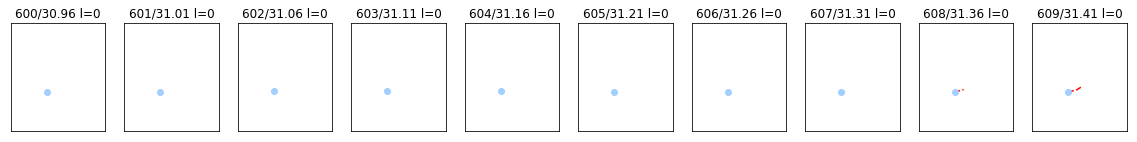

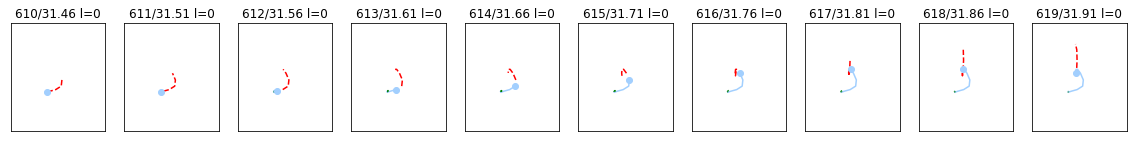

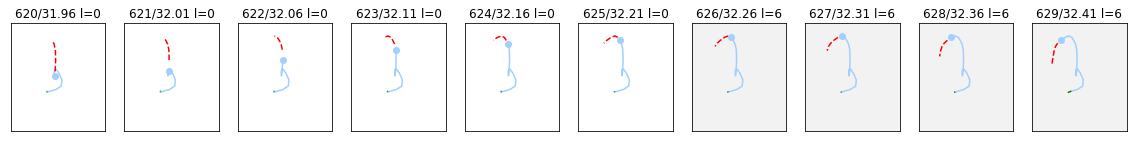

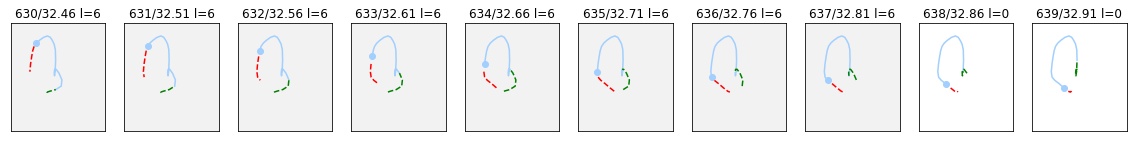

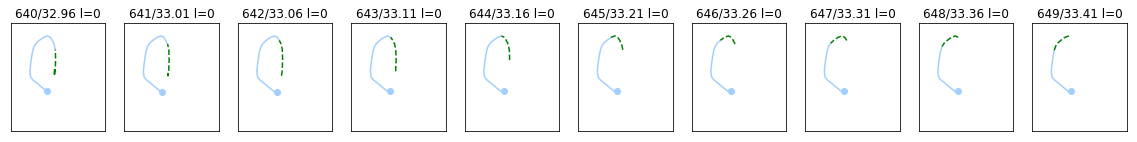

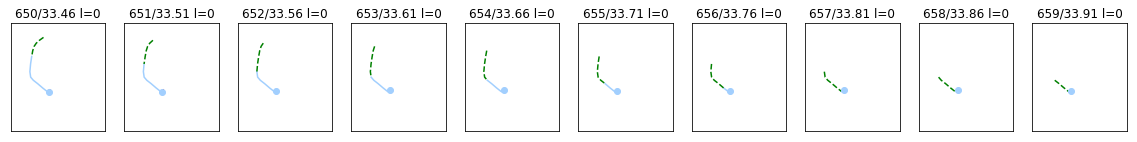

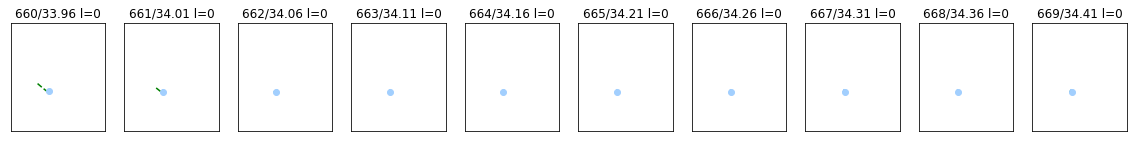

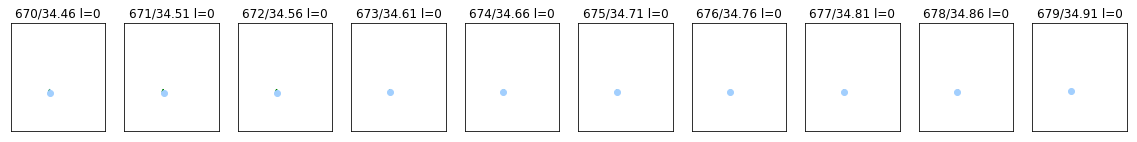

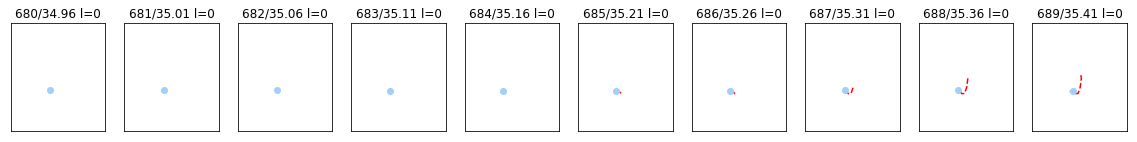

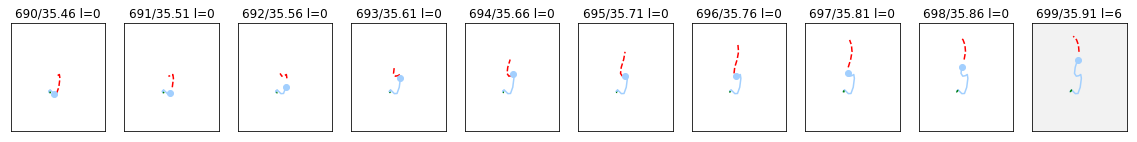

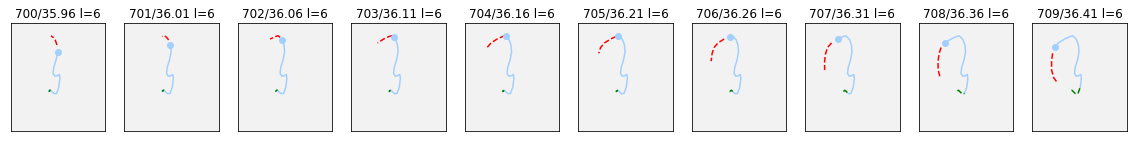

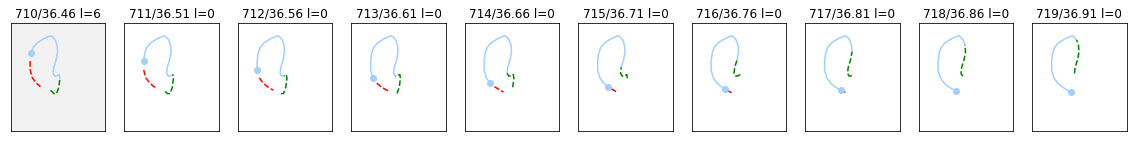

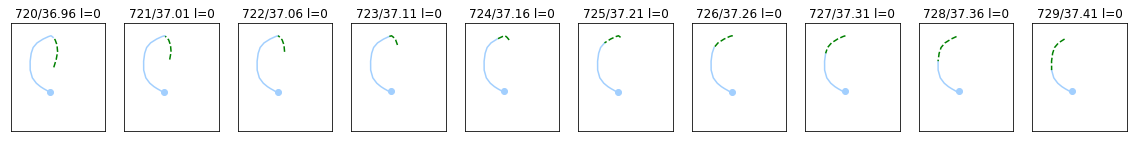

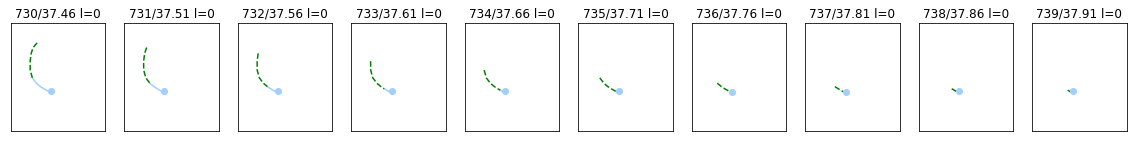

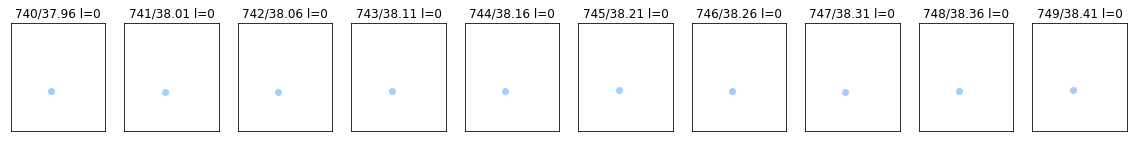

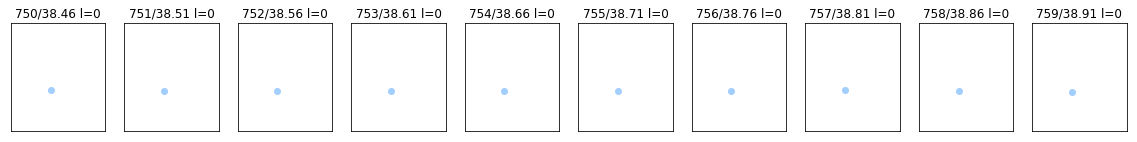

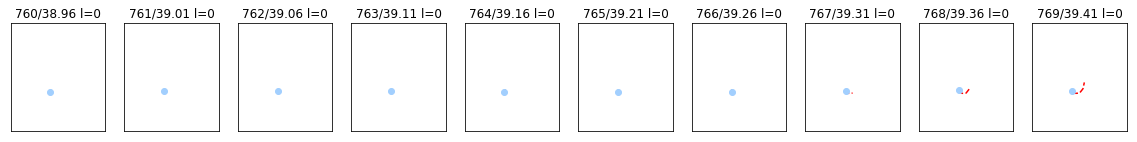

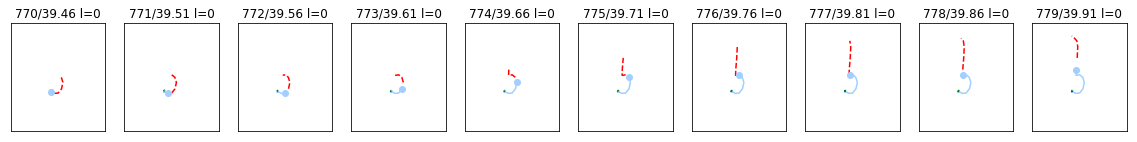

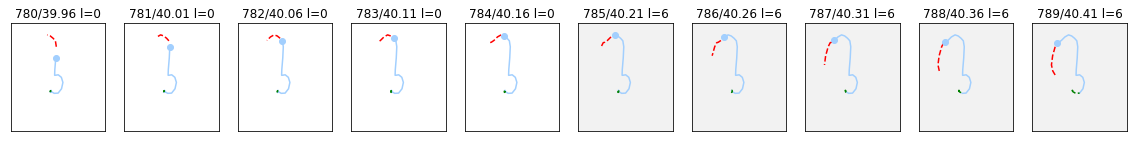

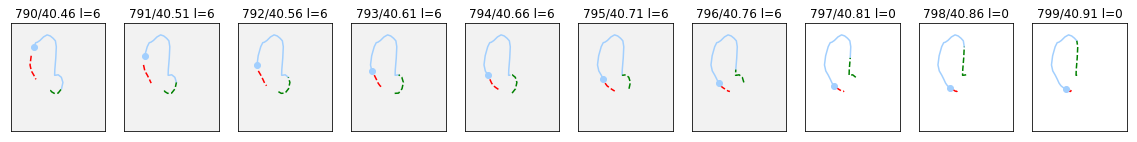

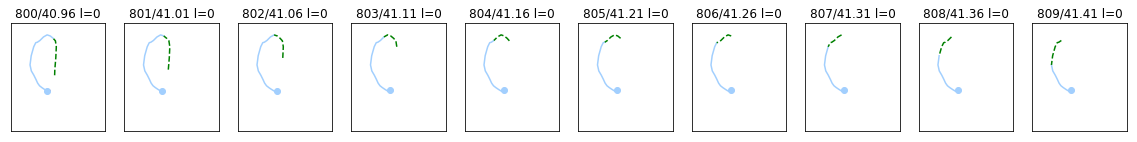

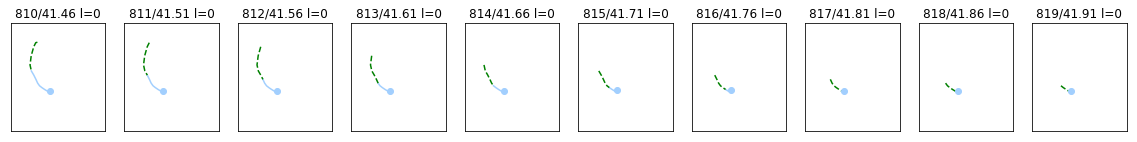

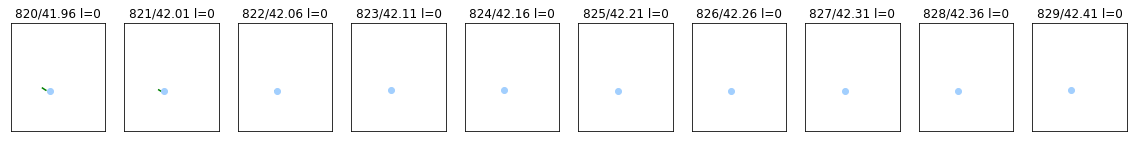

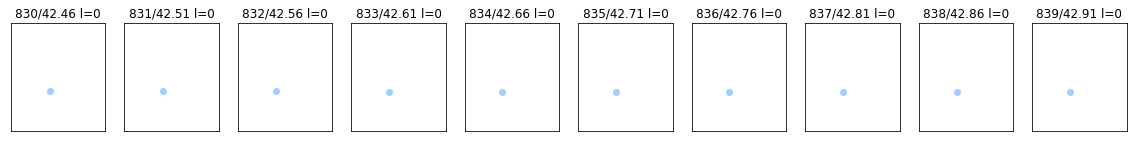

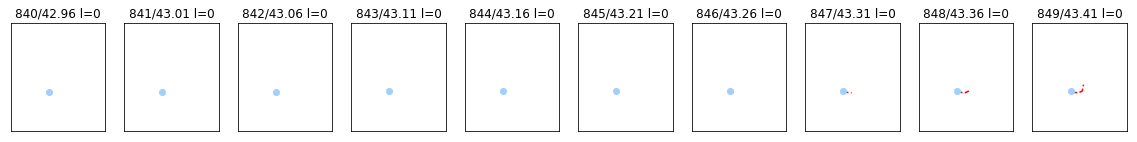

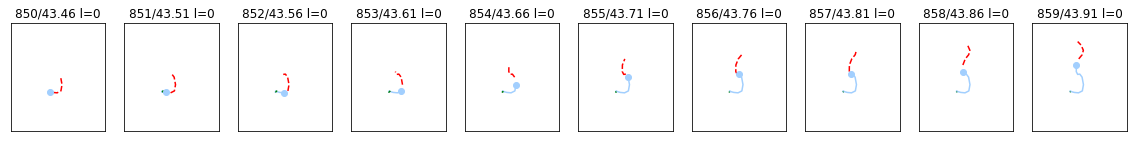

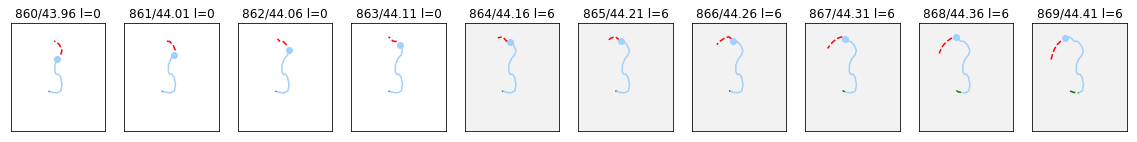

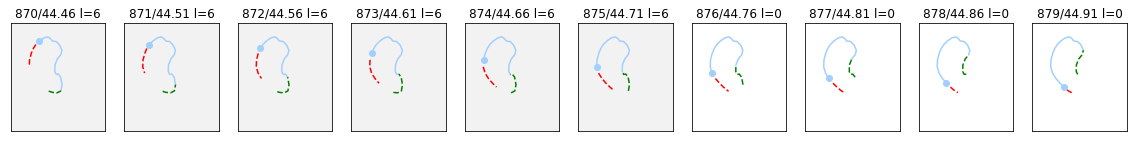

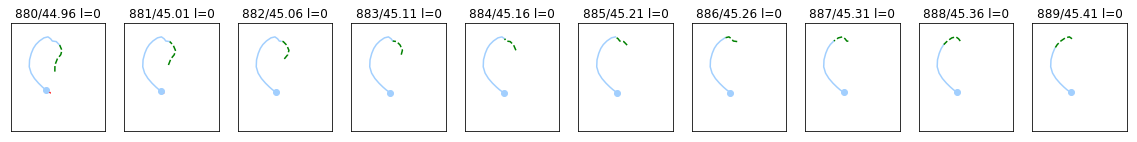

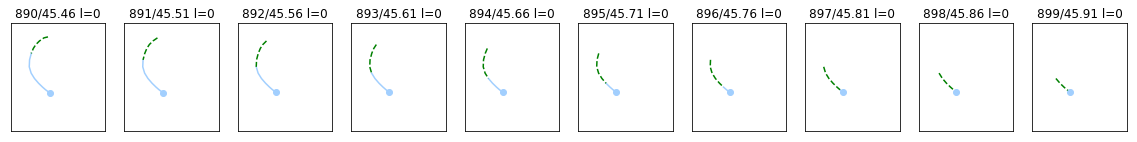

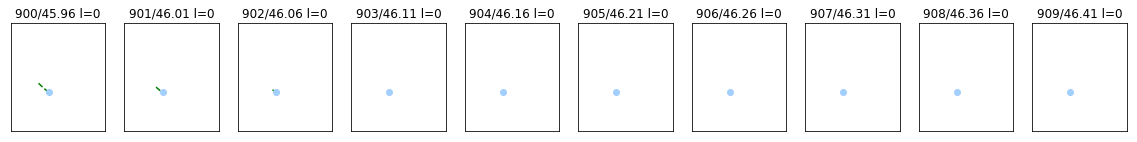

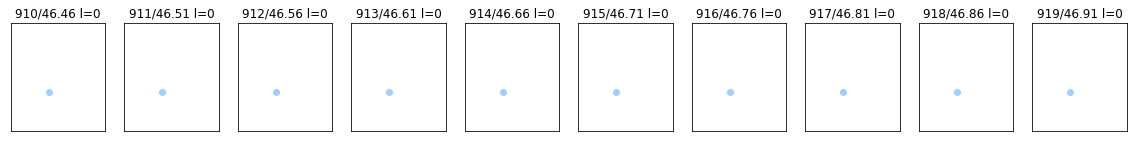

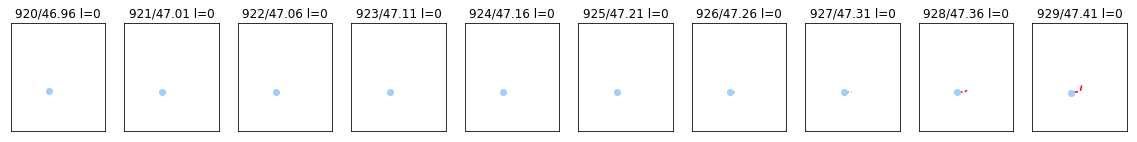

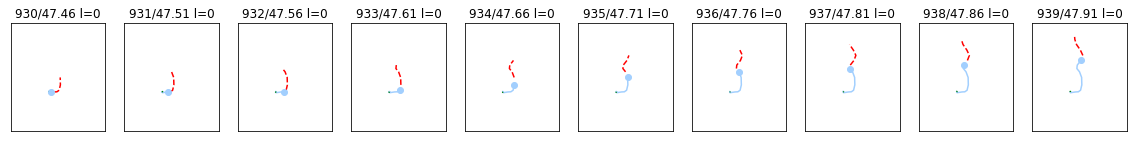

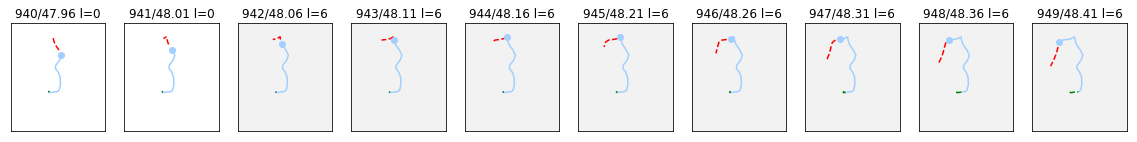

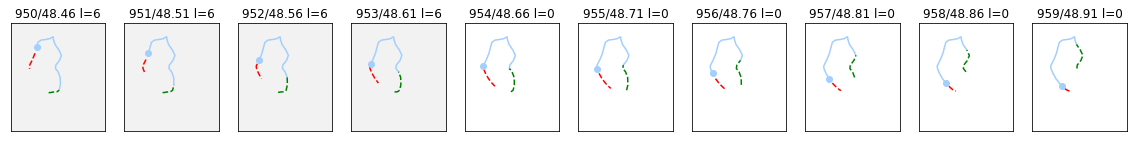

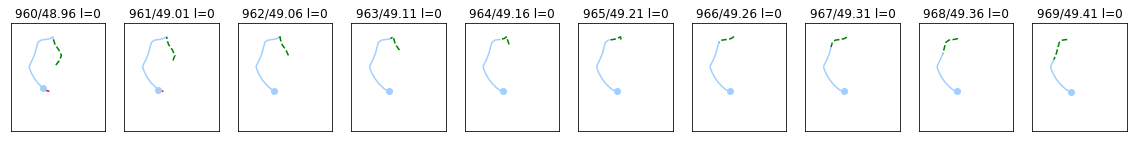

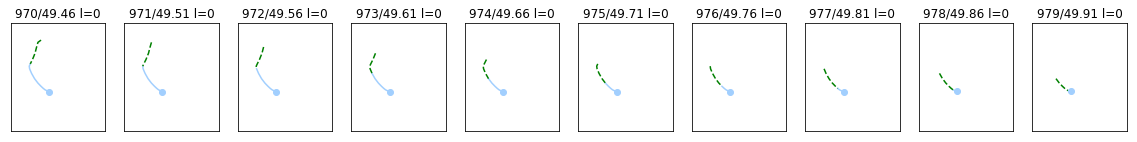

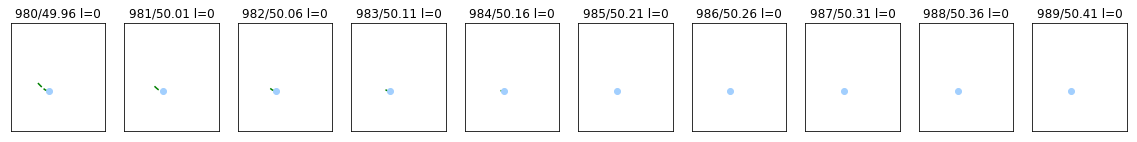

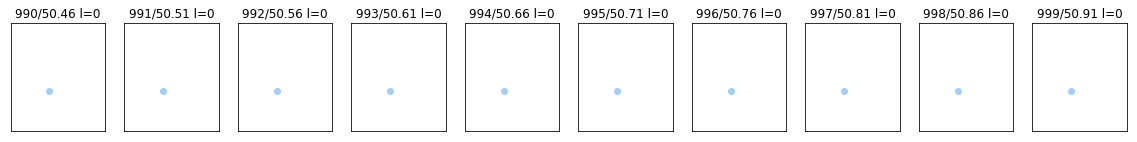

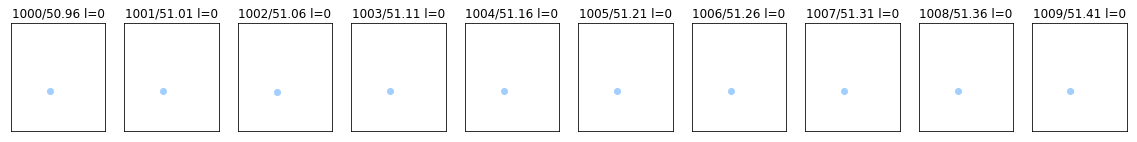

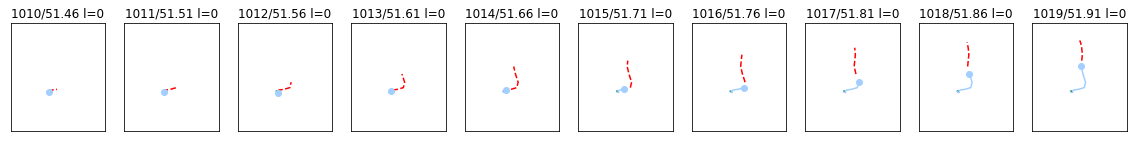

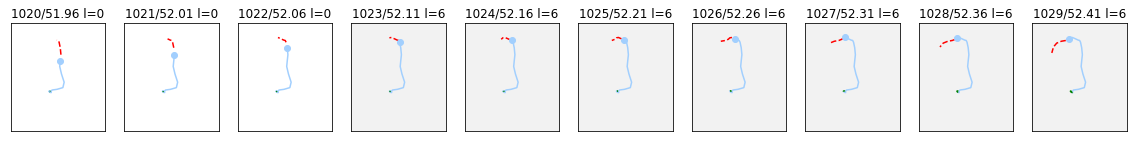

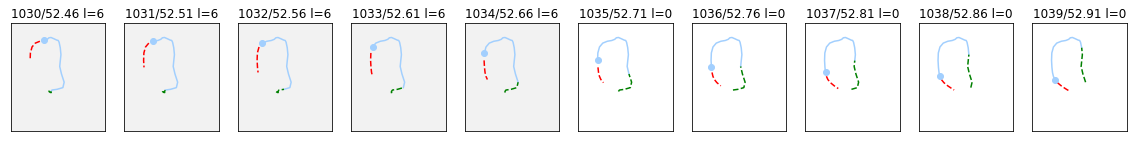

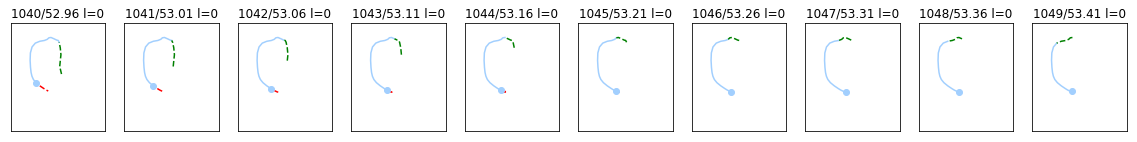

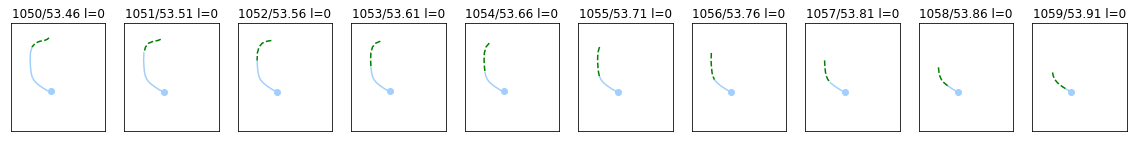

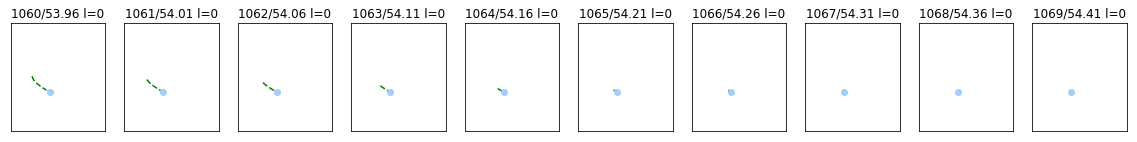

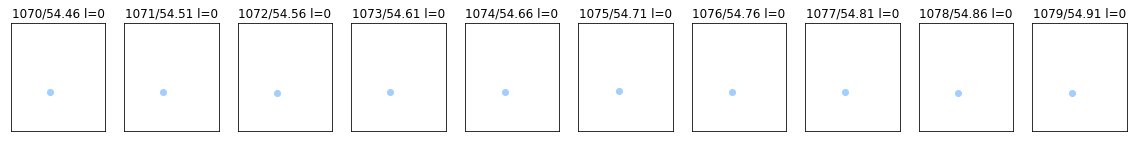

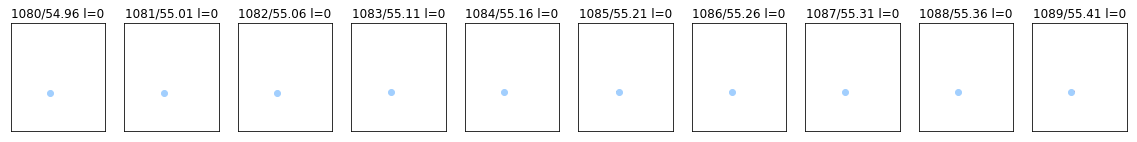

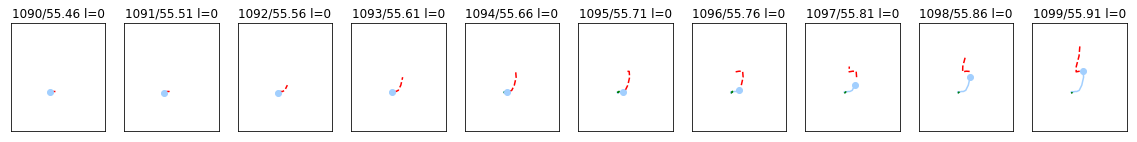

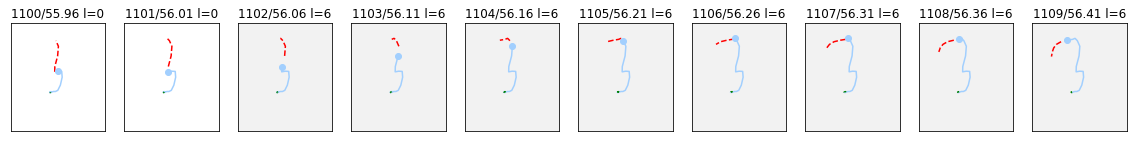

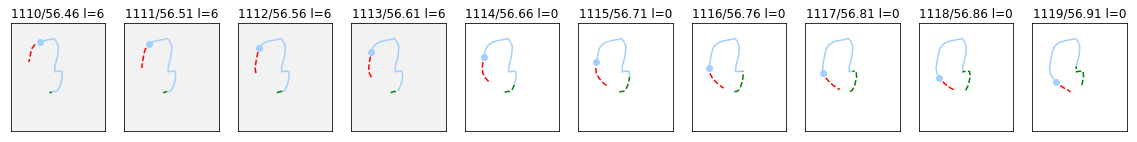

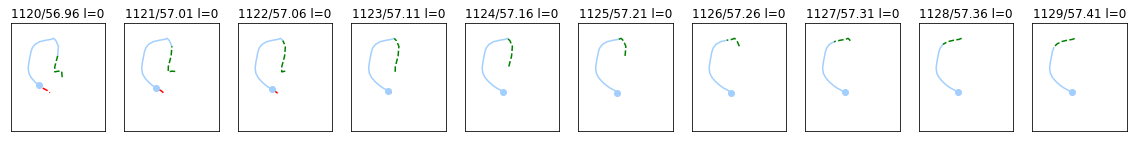

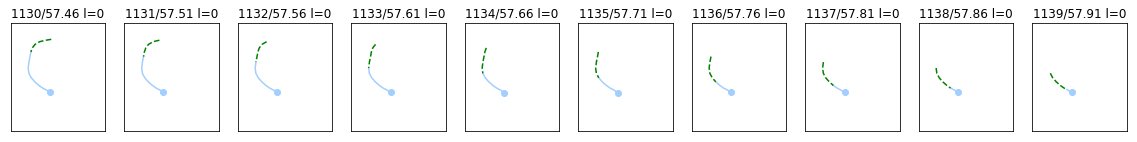

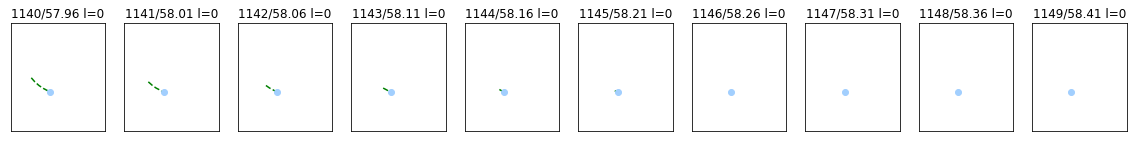

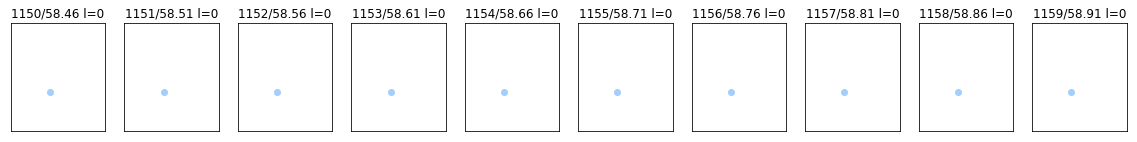

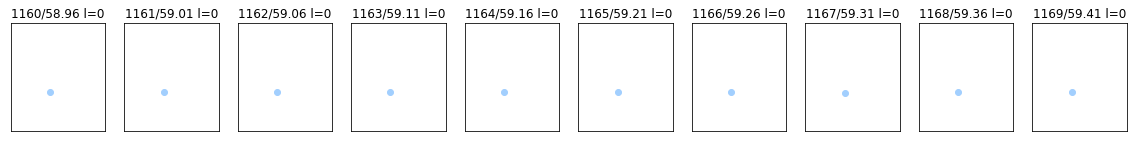

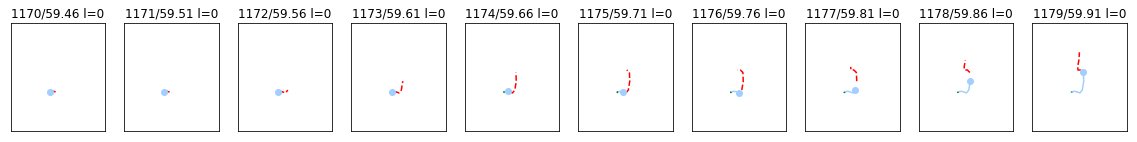

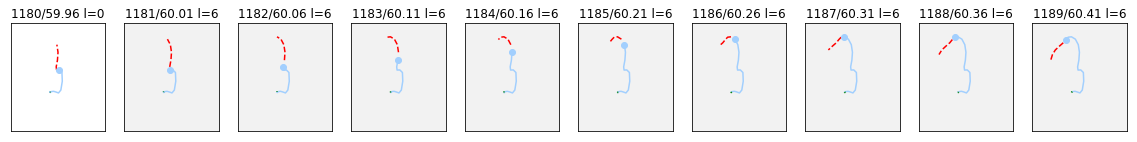

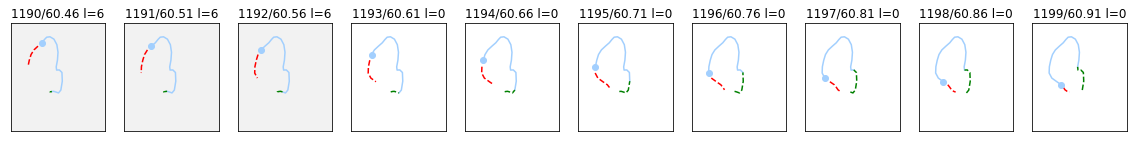

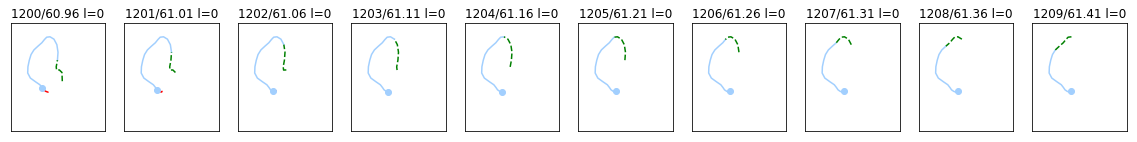

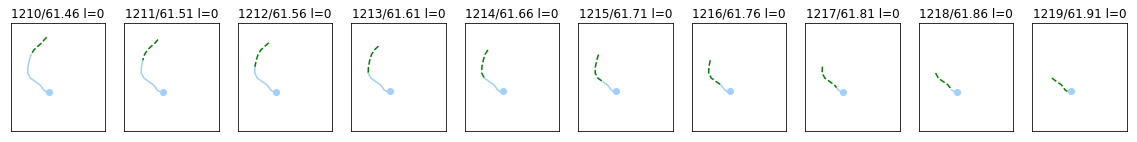

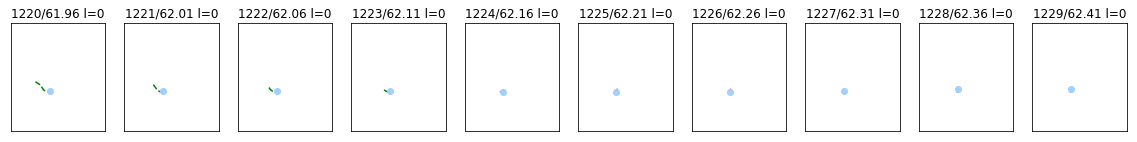

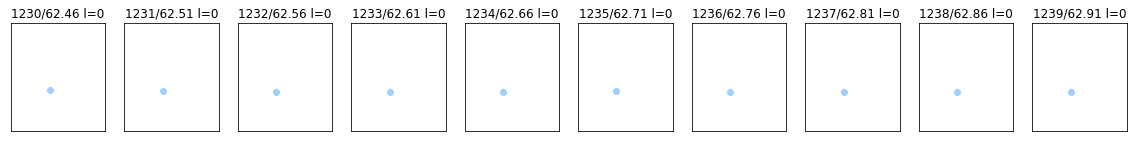

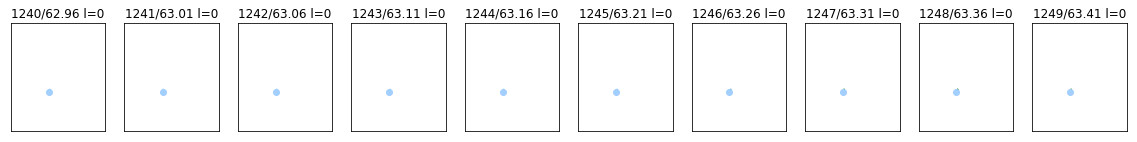

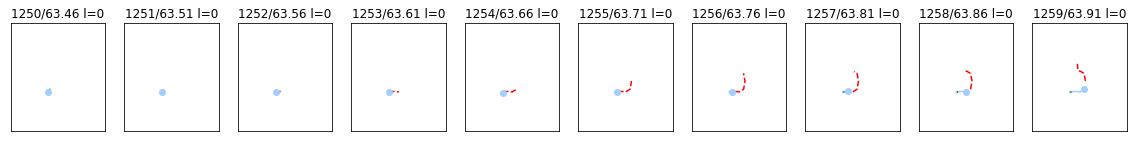

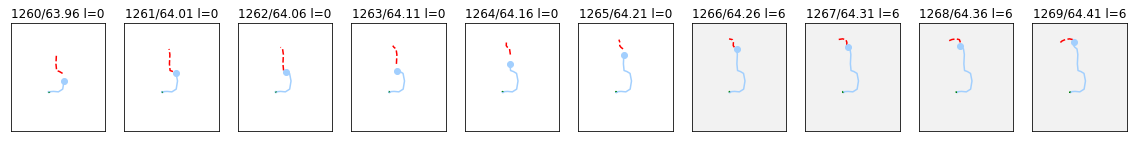

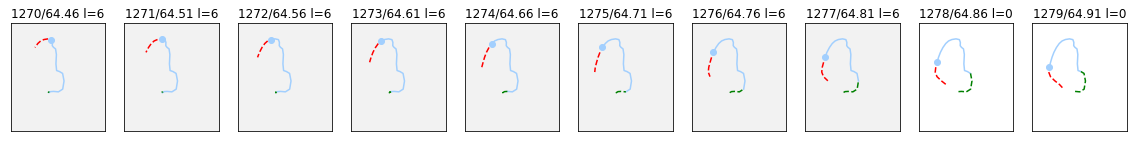

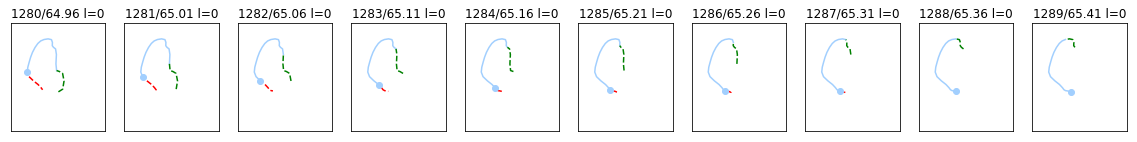

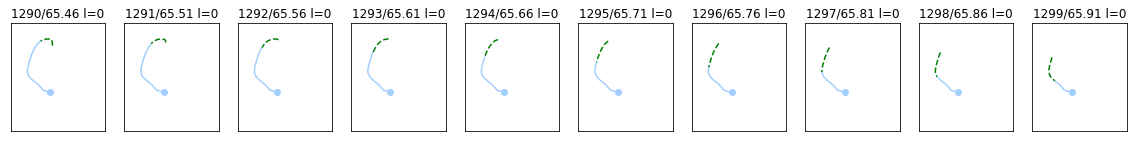

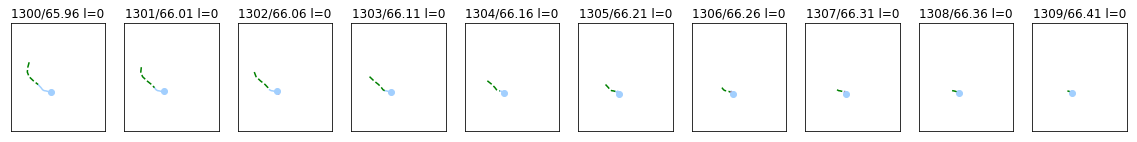

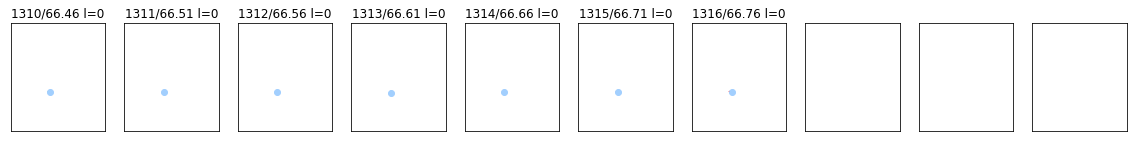

In [15]:
file_id = 6
plot_charts(de, file_id=file_id, tail=5, head=5, plots_per_row=10, body_part='leftWrist', is_frame_based = is_frame_based)

Display the movement endpoints (in milliseconds) of all non-zero labeled gestures:

In [16]:
de.LabelGenerators[file_id].label_df.join(de.LabelGenerators[file_id].label_info)

,label,real_start,real_end,from,to,ignore,diff,l_slack,u_slack,tol_range_indicator
0,6,18700,20450,20025,20625,False,-250,-425,175,True
1,6,20400,22400,22100,22700,False,0,-300,300,True
2,6,22350,24500,24275,24875,False,150,-225,375,True
3,6,26650,28550,28200,28800,False,-100,-350,250,True
4,6,30700,32600,32250,32850,False,-100,-350,250,True
5,6,34650,36350,35900,36500,False,-300,-450,150,True
6,6,38650,40550,40200,40800,False,-100,-350,250,True
7,6,42600,44500,44150,44750,False,-100,-350,250,True
8,6,46500,48400,48050,48650,False,-100,-350,250,True
9,6,50700,52500,52100,52700,False,-200,-400,200,True


Display the indices of movement ends of all non-zero labeled gestures:

In [17]:
lgen = de.LabelGenerators[file_id]
y = lgen.y

gt = GestureTransformer(byrow=True, feature_names=feature_names)
X = gt.transform(lgen.X)

gt = GestureTransformer(feature_names)
P = gt.transform(de.X)

key = 'leftWrist'
kx = key + '_x'
ky = key + '_y'

# get the label which is used in the current file
lab = y[y>0][0]

this_set = True
if not this_set: #use all the data
    movementData = P[np.isclose(de.y,lab),:,:]
else:
    movementData = X[np.isclose(y,lab),:,:]

print(movementData.shape)
movementData = movementData[:,:,[feat_dict[kx],feat_dict[ky]]]
avgMovement = movementData.mean(axis = 0)
avgMovement

(156, 18, 16)


array([[-0.76793779,  0.87494293],
       [-0.81640395,  0.77788106],
       [-0.85413192,  0.66506535],
       [-0.87878606,  0.5397943 ],
       [-0.88832809,  0.40744606],
       [-0.88174108,  0.27482704],
       [-0.85954987,  0.14741872],
       [-0.82420871,  0.02797987],
       [-0.77899511, -0.08159873],
       [-0.72606919, -0.17874978],
       [-0.66712539, -0.26141107],
       [-0.60542608, -0.32910496],
       [-0.54557054, -0.38194432],
       [-0.49100218, -0.4199515 ],
       [-0.44330478, -0.44420799],
       [-0.40329101, -0.45749662],
       [-0.37101706, -0.46214846],
       [-0.34565845, -0.45895557]])